<a href="https://colab.research.google.com/github/Xuanyiyiren/An-enthusiast-of-mathematics-and-physics/blob/main/Ising_Model_Julia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

This is my homework for my course called "Thermodynamics & Statistical Physics (II)".

My homework refers to a [Rajesh Singh's blog](https://rajeshrinet.github.io/blog/2014/ising-model/). In order to prove that I didn't simply take someone else's program and run it, I reproduced it in the newly learned language `Julia` to complete my homework.

My homework has been successfully run on [colab](https://colab.research.google.com/#scrollTo=GJBs_flRovLc), a very convenient platform by Google built for machine learning and AI. I also recommand you to click on the "run in colab" buttom to run it in colab. You can also click on the [sharing link](https://colab.research.google.com/github/Xuanyiyiren/Intersting-things/blob/main/Ising_Model_Julia.ipynb).

This notebook is divided into three parts:
1. The first part is preparation for Julia. This part is especially for running Julia on Colab, which only supports Python by default. I also recommend you to run it in this online lab because it might be a bit hard to build Julia's environment on your local device. This way can avoid a lot of strange questions.
2. The second part is the main part of my homework, the simulation of the Ising model.
3. The third part is a deeper explanation about why I chose Julia and its advantages.

To run this notebook, please read the first part carefully and do what it tells you. If you can run the second code block `versioninfo()` well, then you have successfully installed Julia on Colab.

# Preparation for Julia

<img src="https://github.com/JuliaLang/julia-logo-graphics/raw/master/images/julia-logo-color.png" height="100" /> _Colab Notebook Template_

## Instructions
1. Work on a copy of this notebook: _File_ > _Save a copy in Drive_ (you will need a Google account). Alternatively, you can download the notebook using _File_ > _Download .ipynb_, then upload it to [Colab](https://colab.research.google.com/).
2. If you need a GPU: _Runtime_ > _Change runtime type_ > _Harware accelerator_ = _GPU_.
3. Execute the following cell (click on it and press Ctrl+Enter) to install Julia, IJulia and other packages (if needed, update `JULIA_VERSION` and the other parameters). This takes a couple of minutes.
4. Reload this page (press Ctrl+R, or ⌘+R, or the F5 key) and continue to the next section.

_Notes_:
* If your Colab Runtime gets reset (e.g., due to inactivity), repeat steps 2, 3 and 4.
* After installation, if you want to change the Julia version or activate/deactivate the GPU, you will need to reset the Runtime: _Runtime_ > _Factory reset runtime_ and repeat steps 3 and 4.

In [ ]:
%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.8.2" # any version ≥ 0.7.0
JULIA_PACKAGES="IJulia BenchmarkTools"
JULIA_PACKAGES_IF_GPU="CUDA" # or CuArrays for older Julia versions
JULIA_NUM_THREADS=2
#---------------------------------------------------#

if [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  # Install Packages
  nvidia-smi -L &> /dev/null && export GPU=1 || export GPU=0
  if [ $GPU -eq 1 ]; then
    JULIA_PACKAGES="$JULIA_PACKAGES $JULIA_PACKAGES_IF_GPU"
  fi
  for PKG in `echo $JULIA_PACKAGES`; do
    echo "Installing Julia package $PKG..."
    julia -e 'using Pkg; pkg"add '$PKG'; precompile;"' &> /dev/null
  done

  # Install kernel and rename it to "julia"
  echo "Installing IJulia kernel..."
  julia -e 'using IJulia; IJulia.installkernel("julia", env=Dict(
      "JULIA_NUM_THREADS"=>"'"$JULIA_NUM_THREADS"'"))'
  KERNEL_DIR=`julia -e "using IJulia; print(IJulia.kerneldir())"`
  KERNEL_NAME=`ls -d "$KERNEL_DIR"/julia*`
  mv -f $KERNEL_NAME "$KERNEL_DIR"/julia

  echo ''
  echo "Successfully installed `julia -v`!"
  echo "Please reload this page (press Ctrl+R, ⌘+R, or the F5 key) then"
  echo "jump to the 'Checking the Installation' section."
fi

Installing Julia 1.8.2 on the current Colab Runtime...
2024-06-29 07:50:21 URL:https://julialang-s3.julialang.org/bin/linux/x64/1.8/julia-1.8.2-linux-x86_64.tar.gz [135859273/135859273] -> "/tmp/julia.tar.gz" [1]
Installing Julia package IJulia...
Installing Julia package BenchmarkTools...


## Checking the Installation
The `versioninfo()` function should print your Julia version and some other info about the system:

In [1]:
versioninfo()

Julia Version 1.8.2
Commit 36034abf260 (2022-09-29 15:21 UTC)
Platform Info:
  OS: Linux (x86_64-linux-gnu)
  CPU: 2 × Intel(R) Xeon(R) CPU @ 2.20GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-13.0.1 (ORCJIT, broadwell)
  Threads: 2 on 2 virtual cores
Environment:
  LD_LIBRARY_PATH = /usr/local/nvidia/lib:/usr/local/nvidia/lib64
  JULIA_NUM_THREADS = 2


## Install Packages

In [2]:
using Pkg
Pkg.add("Plots")
using Plots

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed GR_jll ─────────────────────── v0.73.6+0
   Installed Libmount_jll ───────────────── v2.40.1+0
   Installed x265_jll ───────────────────── v3.5.0+0
   Installed LoggingExtras ──────────────── v1.0.3
   Installed Opus_jll ───────────────────── v1.3.2+0
   Installed JpegTurbo_jll ──────────────── v3.0.3+0
   Installed LERC_jll ───────────────────── v3.0.0+1
   Installed libfdk_aac_jll ─────────────── v2.0.2+0
   Installed ConcurrentUtilities ────────── v2.4.1
   Installed Xorg_xkbcomp_jll ───────────── v1.4.6+0
   Installed RelocatableFolders ─────────── v1.0.1
   Installed Unitful ────────────────────── v1.20.0
   Installed Measures ───────────────────── v0.3.2
   Installed Grisu ──────────────────────── v1.0.2
   Installed Contour ────────────────────── v0.6.3
   Installed Xorg_xcb_util_wm_jll ───────── v0.4.1+1
   Installed Xorg_xcb_util_image_jll ────── v0.4.0+1
   Installed Reci

In [3]:
gr()

Plots.GRBackend()

# Ising Model

In [4]:
function initialstate(N)
    2 .* rand(0:1, N, N) .- 1
end

mymod(n::Int,p::Int) = mod(n-1,p)+1

function mcmove(config, beta)
    N = size(config)[1]
    for i in 1:N^2
        a = rand(1:N)
        b = rand(1:N)
        s = config[a,b]
        nb = config[mymod(a+1,N),b] + config[a,mymod(b+1,N)] + config[mymod(a-1,N),b] + config[a,mymod(b-1,N)]
        cost = 2*s*nb
        if cost<0 || rand(Float64)<exp(-cost*beta)
            s*=-1
        end
        config[a,b] = s
    end
    return nothing
end

function calcEnergy(config)
    # calculate energy
    N = size(config)[1]
    energy = 0
    for i in 1:N, j in 1:N
        s = config[i,j]
        nb = config[mymod(i+1,N),j] + config[i,mymod(j+1,N)] + config[mymod(i-1,N),j] + config[i,mymod(j-1,N)]
        energy += -nb*s
    end
    return energy/4
end

function calcMag(config)
    # Magnetization of a given configuration
    return sum(config)
end

calcMag (generic function with 1 method)

In [5]:
a = initialstate(2)

2×2 Matrix{Int64}:
 -1   1
  1  -1

In [6]:
nt = 88        # number for temperature sample points
N = 16         # size of the lattice
eqSteps = 1024 # number of MC sweeps for equilibration
mcSteps = 1024 # number of MC sweeps for calculation

T_list = range(1.53, 3.28, nt)
E,M,C,X = zeros(nt),zeros(nt),zeros(nt),zeros(nt)
n1 = 1/(mcSteps*N^2)
n2 = n1/mcSteps

3.725290298461914e-9

In [7]:
for T_index in 1:nt
    E1 = M1 = E2 = M2 = 0
    config = initialstate(N)
    beta = 1/T_list[T_index]
    beta2 = beta^2

    for i in 1:eqSteps
        mcmove(config, beta)
    end

    for i in 1:mcSteps
        mcmove(config,beta)
        Ene = calcEnergy(config)
        Mag = calcMag(config)

        E1 += Ene
        M1 += Mag
        E2 += Ene^2
        M2 += Mag^2
    end
    E[T_index] = E1*n1
    M[T_index] = M1*n1
    C[T_index] = (n1*E2 - n2*E1*E1)*beta2
    X[T_index] = (n1*M2 - n2*M1*M1)*beta2
end

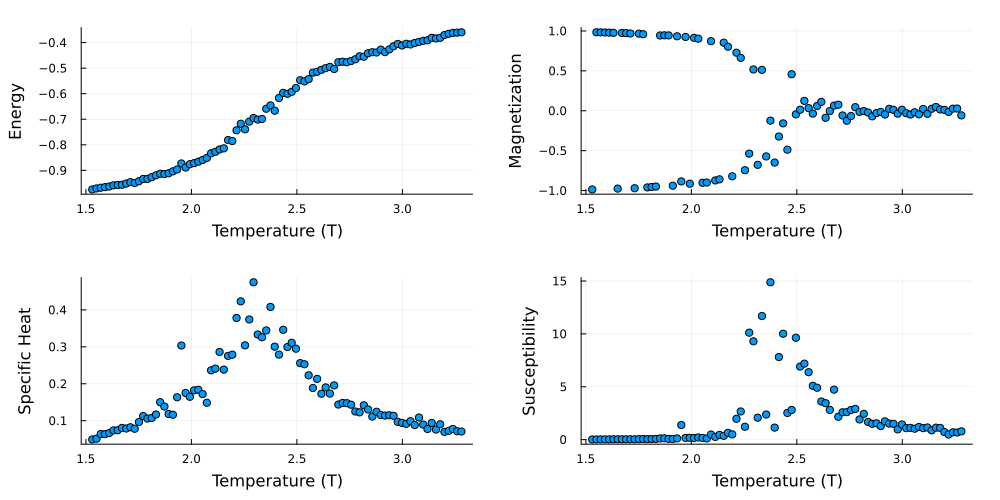

In [12]:
p1 = scatter(T_list, E , label = nothing , xlabel = "Temperature (T)", ylabel = "Energy")
p2 = scatter(T_list, M , label = nothing , xlabel = "Temperature (T)", ylabel = "Magnetization")
p3 = scatter(T_list, C , label = nothing , xlabel = "Temperature (T)", ylabel = "Specific Heat")
p4 = scatter(T_list, X , label = nothing , xlabel = "Temperature (T)", ylabel = "Susceptibility")
using Plots.PlotMeasures
plot(p1, p2, p3, p4, layout=(2,2),size = (1000,500),margin = 5mm)

The same program takes about $10 \,\rm{min}$ in python. But in julia, it only takes $3 \, \rm{s}$! The python code is also shared by the link: [https://colab.research.google.com/drive/1z0RHIQZXBhQFb2CFY1Pwwl9ohQuTRDMS](https://colab.research.google.com/drive/1z0RHIQZXBhQFb2CFY1Pwwl9ohQuTRDMS).

This is an amazing result; the Magnetization-Temperature plot has two lines before the critical temperature, one positive and another negative. This is theoretically correct. The reason might be the difference between python and julia's random number generator.



# Why julia

## 1. [Julia is a fast](https://github.com/JuliaAcademy/Introduction-to-Julia/blob/main/9%20-%20Julia%20is%20fast.ipynb)

Someone has tested the speed of C,python,and julia. He cerate a list with length of $10^7$, and to get the sum of this list. The result is here

- C -ffast-math...............1.8
- Julia built-in..............1.9
- Python numpy................1.9
- Julia hand-written simd.....2.4
- C...........................9.4
- Julia hand-written..........9.4
- Python built-in...........875.8
- Python hand-written......1011.9

We can see that julia is as fast as C! And python is much slower than them.

## 2. Julia can run in a interactive nootbook

There are tow ways to run julia in notebook:
1. [Pluto](https://plutojl.org/): a new types of notebooks with may new feathers.
2. [Ijulia](https://julialang.github.io/IJulia.jl/stable/): Like Ipython.

Julia can not only runs as fast as C, but also can runs in interactive notebooks! This gives us a big advantages.

I originally what to use Pluto, but its package managements confused me. And I only have a limited time to finish this homework.

By the way, julia can also be written in a script like C and Matlab.

## 3. Julia has many packages especially for scientific computing and many of them are build-in

## 4. Julia's grammer is very friendly

Julia's grammer is as friendly as Matlab and Mathematica.

It is said that julia is the best language for scientific computing.